# Ariel data challenge model training

## 1. Notebook set up

### 1.1. Imports & environment

In [1]:
# Standard library imports
import json
import os
import time
from pathlib import Path

# Third party imports
from kaggle_secrets import UserSecretsClient
import matplotlib.pyplot as plt
import tensorflow as tf

# Project imports
from ariel_data_preprocessing.data_generator_functions import make_training_datasets

# Set Kaggle credentials for model upload
user_secrets = UserSecretsClient()
os.environ['KAGGLE_USERNAME'] = user_secrets.get_secret('KAGGLE_USERNAME')
os.environ['KAGGLE_KEY'] = user_secrets.get_secret('KAGGLE_KEY')

2025-09-22 04:06:26.601763: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758513986.796501      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758513986.849608      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### 1.2. Model hyperparameters

In [2]:
wavelengths = 283
sample_size = 372
batch_size = 4
steps = 431
learning_rate = 0.0007103203515277739
l_one = 0.9381346432258663
l_two = 0.36282682418942663
cnn_layers = 3
first_filter_set = 73
second_filter_set = 34
third_filter_set = 48
first_filter_size = 2
second_filter_size = 5
third_filter_size = 3
dense_units = 104
beta_one = 0.72
beta_two = 0.93
amsgrad = True
weight_decay = 0.016
use_ema = True

epochs = 2000
total_ksteps = int((epochs * steps) / 1000)

## 2. Initalize data generator

In [3]:
training_dataset, _, _ = make_training_datasets(
    data_file='/kaggle/input/ariel-training-data/train.h5',
    sample_size=sample_size,
    validation=False
)

I0000 00:00:1758514001.908614      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


## 3. CNN

### 3.1. Model definition

In [4]:
def compile_model(
        sample_size: int,
        wavelengths: int,
        learning_rate: float,
        l1: float,
        l2: float,
        first_filter_set: int,
        second_filter_set: int,
        third_filter_set: int,
        first_filter_size: int,
        second_filter_size: int,
        third_filter_size: int,
        dense_units: int,
        beta_one: float,
        beta_two: float,
        amsgrad: bool,
        weight_decay: float,
        use_ema: bool
) -> tf.keras.Model:

    '''Builds the convolutional neural network regression model'''

    # Set-up the L1L2 for the dense layers
    regularizer = tf.keras.regularizers.L1L2(l1=l1, l2=l2)

    # Define the model layers in order
    model = tf.keras.Sequential([
        tf.keras.layers.Input((sample_size,wavelengths,1)),
        tf.keras.layers.Conv2D(
            first_filter_set,
            first_filter_size,
            padding='same',
            activation='relu',
        ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(
            second_filter_set,
            second_filter_size,
            padding='same',
            activation='relu',
        ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(
            third_filter_set,
            third_filter_size,
            padding='same',
            activation='relu',
        ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(
            dense_units,
            kernel_regularizer=regularizer,
            activation='relu',
        ),
        tf.keras.layers.Dense(wavelengths, activation='linear')
    ])

    # Define the optimizer
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=learning_rate,
        beta_1=beta_one,
        beta_2=beta_two,
        amsgrad=amsgrad,
        weight_decay=weight_decay,
        use_ema=use_ema
    )

    # Compile the model
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.MeanSquaredError(name='MSE'),
        metrics=[
            tf.keras.metrics.RootMeanSquaredError(name='RMSE')
        ]
    )

    return model

In [5]:
model = compile_model(
    sample_size=sample_size,
    wavelengths=wavelengths,
    learning_rate=learning_rate,
    l1=l_one,
    l2=l_two,
    first_filter_set=first_filter_set,
    second_filter_set=second_filter_set,
    third_filter_set=third_filter_set,
    first_filter_size=first_filter_size,
    second_filter_size=second_filter_size,
    third_filter_size=third_filter_size,
    dense_units=dense_units,
    beta_one=beta_one,
    beta_two=beta_two,
    amsgrad=amsgrad,
    weight_decay=weight_decay,
    use_ema=use_ema,
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 372, 283, 73)   │           365 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 186, 141, 73)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 186, 141, 34)   │        62,084 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 93, 70, 34)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 93, 70, 48)     │        14,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 46, 35, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 77280)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 104)            │     8,037,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 283)            │        29,715 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,144,124 (31.07 MB)

 Trainable params: 8,144,124 (31.07 MB)

 Non-trainable params: 0 (0.00 B)

### 3.2. Model training

In [6]:
print(f'Training model for {total_ksteps} ksteps')
start_time = time.time()

training_results = model.fit(
    training_dataset.batch(batch_size),
    epochs=epochs,
    steps_per_epoch=steps,
    verbose=0
)

print(f'Training complete in {(time.time() - start_time)/60:.1f} minutes')

Training model for 862 ksteps


I0000 00:00:1758514007.342603      69 service.cc:148] XLA service 0x7b0b34010500 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758514007.343445      69 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1758514007.722822      69 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1758514011.448512      69 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Training complete in 296.2 minutes


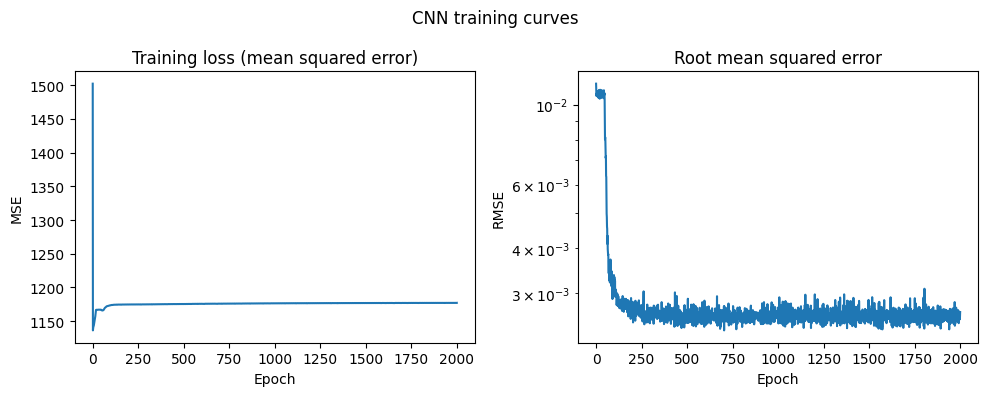

In [7]:
# Set-up a 1x2 figure for accuracy and binary cross-entropy
fig, axs=plt.subplots(1,2, figsize=(10,4))

# Add the main title
fig.suptitle('CNN training curves', size='large')

# Plot training loss
axs[0].set_title('Training loss (mean squared error)')
axs[0].plot(training_results.history['loss'])
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('MSE')

# Plot training RMSE
axs[1].set_title('Root mean squared error')
axs[1].plot(training_results.history['RMSE'])
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('RMSE')
axs[1].set_yscale('log')

# Show the plot
fig.tight_layout()

### 3.3. Save/upload the model

In [8]:
Path('/kaggle/working/model').mkdir(parents=True, exist_ok=True)
model_save_file = f'/kaggle/working/model/ariel-cnn-8.1M-{total_ksteps}ksteps.keras'
model.save(model_save_file)

In [9]:
!kaggle datasets metadata gperdrizet/ariel-cnn -p ./model

with open('model/dataset-metadata.json', 'r') as f:
    data = json.loads(json.load(f))

data['id'] = 'gperdrizet/ariel-cnn'

with open('model/dataset-metadata.json', "w") as f:
    json.dump(data, f)

!kaggle datasets version -p ./model/ -m "Updated ariel CNN"

Downloaded metadata to ./model/dataset-metadata.json
Starting upload for file ariel-cnn-8.1M-862ksteps.keras
100%|████████████████████████████████████████| 155M/155M [00:02<00:00, 78.2MB/s]
Upload successful: ariel-cnn-8.1M-862ksteps.keras (155MB)
Dataset version is being created. Please check progress at https://www.kaggle.com/datasets/gperdrizet/ariel-cnn
